<a href="https://colab.research.google.com/github/stnvapm/Project-Future/blob/main/Machine%20learning_Airbnb%20Prediction%20of%20prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries


In [2]:
import pandas as pd
import numpy as np

 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import accuracy_score,explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.cm as cmx
import matplotlib.colors as colors
%matplotlib inline

## Importing csv's

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
ame_df=pd.read_csv('/content/gdrive/MyDrive/amenities.csv')
host_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/hosts.csv', header=None)
host_df.columns=['host_id','host_since','host_about','host_response_rate','host_acceptance_rate','host_is_superhost']
cal_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/calendar.csv', header=None)
cal_df.columns=['propertyId','datekey','available','price','adjusted_price']
prop_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/property.csv', header=None)
prop_df.columns=['propertyId','description','longitude','latitude','neighborhood_overview','accommodates','bathrooms_text','bedrooms','beds',
	'price','instant_bookable','host_id','property_type','neighbourhood','room_type']
rev_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/reviews.csv', header=None)
rev_df.columns=['propertyId','id','datekey','reviewer_id','comments']
revS_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/reviewsSummary.csv', header=None)
revS_df.columns=['propertyId','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review_key','last_review_key','review_scores_rating',
                 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin',
                 'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']
frev_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/fact_reviews.csv', header=None)
frev_df.columns=['property_id','host_id','review_id','datekey','number_of_reviews']
fava_df=pd.read_csv('/content/gdrive/MyDrive/regeneration notebooks/csv/fact_availability.csv', header=None)
fava_df.columns=['property_id','host_id','datekey','Available','Price']


## Data Cleaning

Changing the *bathrooms_text* from string to float

In [9]:
words1=('Shared half-bath','Half-bath','Private half-bath')
for word in words1:
     prop_df['bathrooms_text'] = prop_df['bathrooms_text'].str.replace(word, '0.5')

words2=('baths','bath','private','shared','bath','Half-bath',' ','half-bath','Shared','Private','half-','Half-')
for word in words2:
     prop_df['bathrooms_text'] = prop_df['bathrooms_text'].str.replace(word, '')

prop_df['bathrooms_text'] = prop_df['bathrooms_text'] .astype(float)

Changing the *instant_bookable* from *t, f* to *1, 0*

In [10]:
prop_df['instant_bookable']=prop_df['instant_bookable'].str.replace('t','1')
prop_df['instant_bookable']=prop_df['instant_bookable'].str.replace('f','0')
prop_df['instant_bookable'] = prop_df['instant_bookable'] .astype(int)

Droping column *neighborhood_overview* because it is not needed

In [11]:
prop_df=prop_df.drop(columns = ['neighborhood_overview'])

Merging the dataframe *property* with the *host* one, so we can know if a property is advertised from a superhost.

In [12]:
prop_df2=pd.merge(prop_df,host_df, how='left', on='host_id')
prop_df2=prop_df2.drop(columns = ['host_since', 'host_about','host_response_rate','host_acceptance_rate'])
prop_df2.head()

,propertyId,description,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,property_type,neighbourhood,room_type,host_is_superhost
0,2818,Quiet Garden View Room & Super Fast WiFi<br />...,4.94142,52.36575,2,1.5,1.0,2.0,59.0,1,3159,Private room in apartment,Oostelijk Havengebied - Indische Buurt,Private room,1.0
1,20168,17th century Dutch townhouse in the heart of t...,4.89396,52.36424,2,1.0,1.0,1.0,236.0,1,59484,Private room in townhouse,Centrum-Oost,Private room,0.0
2,25428,Lovely apt in Centre ( lift & fireplace) near ...,4.88339,52.37297,3,1.0,1.0,1.0,125.0,0,56142,Entire apartment,Centrum-West,Entire home/apt,1.0
3,27886,Stylish and romantic houseboat on fantastic hi...,4.89188,52.38761,2,1.5,1.0,1.0,138.0,1,97647,Private room in houseboat,Centrum-West,Private room,1.0
4,28871,<b>The space</b><br />In a monumental house ri...,4.89092,52.36719,2,1.0,1.0,1.0,75.0,0,124245,Private room in apartment,Centrum-West,Private room,1.0


Filling the Nan in the *bedrooms* and *beds* columns. Our logic is:
If in the *description* of the property we find the word studio then we replace the nan in the *bedrooms* with 0. If it is not then we replace it with the value of the *deds*. The latter was decided after comparing the *bedrooms* and *beds* and finding out that 12978 out of 18781 have the same number of *bedrooms* and *beds*. After that 4 remained NaN so we dropped the rows.

In [13]:
prop_df2['description']=prop_df2['description'].fillna(' ')

In [14]:
pd.set_option('display.max_rows', 20)

In [15]:
for i in range(len(prop_df2)):
  if pd.isnull(prop_df2.iloc[i,6]):
        if 'studio' in prop_df2.iloc[i,1].lower():
          prop_df2.iloc[i,6]=0
        else:
          prop_df2.iloc[i,6]=prop_df2.iloc[i,7]
prop_df2['bedrooms'].isna().sum()

4

In [16]:
for i in range(len(prop_df2)):
    if pd.isnull(prop_df2.iloc[i,7]):
      prop_df2.iloc[i,7]=prop_df2.iloc[i,6]
prop_df2['beds'].isna().sum()

4

In [17]:
prop_df2=prop_df2.dropna(subset=['bedrooms'])
prop_df2=prop_df2.dropna(subset=['bathrooms_text'])
prop_df2['host_is_superhost']=prop_df2['host_is_superhost'].fillna(0)

In [18]:
prop_df2.isna().sum()

propertyId           0
description          0
longitude            0
latitude             0
accommodates         0
bathrooms_text       0
bedrooms             0
beds                 0
price                0
instant_bookable     0
host_id              0
property_type        0
neighbourhood        0
room_type            0
host_is_superhost    0
dtype: int64

Grouping the different *property_types* into 6 categories.


*   Category 1: Entire house etc - anything with entire
*   Category 2: Boats, Houseboats
*   Category 3: Private Rooms in apartments/houses etc
*    Category 4: Private Rooms in hotels/hostels etc
*    Category 5: Shared Rooms
*    Category 6: Other


In [19]:
dict_of_prop_typ = {
     ('Entire apartment'):1,('Entire house'):1, ('Entire townhouse'):1,('Entire loft'):1,('Entire condominium'):1,('Entire serviced apartment'):1,('Entire guest suite'):1,('Entire villa'):1,('Entire cottage'):1,
     ('Entire guesthouse'):1,('Entire place'):1,('Entire floor'):1,('Entire cabin'):1,('Entire bed and breakfast'):1,('Entire bungalow'):1,('Entire home/apt'):1,('Entire chalet'): 1,
     ('Boat'): 2,('Houseboat'): 2,
     ('Private room in apartment'):3,('Private room in house'):3,('Private room in bed and breakfast'):3,('Private room in townhouse'):3,('Private room in houseboat'):3,('Private room in guest suite'):3,
     ('Private room in boat'):3,('Private room in condominium'):3,('Private room in loft'):3,('Private room in hostel'):3,('Private room'):3,('Private room in guesthouse'):3,('Private room in serviced apartment'):3,
     ('Private room in villa'):3,('Private room in tiny house'):3,('Private room in farm stay'):3,('Private room in cabin'):3,('Private room in floor'):3,('Private room in dome house'):3,
     ('Private room in island'):3,('Private room in camper/rv'):3,('Private room in earth house'):3,('Private room in bungalow'): 3,
     ('Room in bed and breakfast'):4,('Room in hotel'):4,('Room in boutique hotel'):4,('Room in hostel'):4,('Room in aparthotel'):4,('Room in casa particular'):4,('Room in serviced apartment'): 4,
     ('Shared room in apartment'):5,('Shared room in boat'):5,('Shared room in house'):5,('Shared room in houseboat'):5,('Shared room in bed and breakfast'):5,('Shared room in loft'):5,('Shared room in hostel'):5,
     ('Shared room in camper/rv'): 5,
     ('Tiny house'):6,('Barn'):6,('Yurt'):6,('Campsite'):6,('Camper/RV'):6,('Earth house'):6,('Tipi'):6,('Cave'):6,('Bus'):6,('Lighthouse'): 6}


In [20]:
prop_df2['property_type']=prop_df2['property_type'].map(dict_of_prop_typ)

In [21]:
prop_df2.head()

,propertyId,description,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,property_type,neighbourhood,room_type,host_is_superhost
0,2818,Quiet Garden View Room & Super Fast WiFi<br />...,4.94142,52.36575,2,1.5,1.0,2.0,59.0,1,3159,3,Oostelijk Havengebied - Indische Buurt,Private room,1.0
1,20168,17th century Dutch townhouse in the heart of t...,4.89396,52.36424,2,1.0,1.0,1.0,236.0,1,59484,3,Centrum-Oost,Private room,0.0
2,25428,Lovely apt in Centre ( lift & fireplace) near ...,4.88339,52.37297,3,1.0,1.0,1.0,125.0,0,56142,1,Centrum-West,Entire home/apt,1.0
3,27886,Stylish and romantic houseboat on fantastic hi...,4.89188,52.38761,2,1.5,1.0,1.0,138.0,1,97647,3,Centrum-West,Private room,1.0
4,28871,<b>The space</b><br />In a monumental house ri...,4.89092,52.36719,2,1.0,1.0,1.0,75.0,0,124245,3,Centrum-West,Private room,1.0


Grouping the different *room_types* into 4 categories.

*   Category 1: Entire home/apt
*   Category 2: Private room
*   Category 3: Hotel room
*    Category 4: Shared room

In [22]:
dict_room_types={'Private room':2, 'Entire home/apt':1, 'Hotel room':3, 'Shared room':4}
prop_df2['room_type']=prop_df2['room_type'].map(dict_room_types)
prop_df2.head()

,propertyId,description,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,property_type,neighbourhood,room_type,host_is_superhost
0,2818,Quiet Garden View Room & Super Fast WiFi<br />...,4.94142,52.36575,2,1.5,1.0,2.0,59.0,1,3159,3,Oostelijk Havengebied - Indische Buurt,2,1.0
1,20168,17th century Dutch townhouse in the heart of t...,4.89396,52.36424,2,1.0,1.0,1.0,236.0,1,59484,3,Centrum-Oost,2,0.0
2,25428,Lovely apt in Centre ( lift & fireplace) near ...,4.88339,52.37297,3,1.0,1.0,1.0,125.0,0,56142,1,Centrum-West,1,1.0
3,27886,Stylish and romantic houseboat on fantastic hi...,4.89188,52.38761,2,1.5,1.0,1.0,138.0,1,97647,3,Centrum-West,2,1.0
4,28871,<b>The space</b><br />In a monumental house ri...,4.89092,52.36719,2,1.0,1.0,1.0,75.0,0,124245,3,Centrum-West,2,1.0


In [23]:
prop_df2=prop_df2.drop(columns = ['description'])

One hot encoding for columns: *neighbourhood* , *room_type* and *property_type*

In [24]:
#prop_df3=pd.get_dummies(prop_df2,columns=['neighbourhood','room_type','property_type'])
prop_df3=pd.get_dummies(prop_df2,columns=['room_type','property_type'])
prop_df3.head()

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,...,room_type_1,room_type_2,room_type_3,room_type_4,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6
0,2818,4.94142,52.36575,2,1.5,1.0,2.0,59.0,1,3159,...,0,1,0,0,0,0,1,0,0,0
1,20168,4.89396,52.36424,2,1.0,1.0,1.0,236.0,1,59484,...,0,1,0,0,0,0,1,0,0,0
2,25428,4.88339,52.37297,3,1.0,1.0,1.0,125.0,0,56142,...,1,0,0,0,1,0,0,0,0,0
3,27886,4.89188,52.38761,2,1.5,1.0,1.0,138.0,1,97647,...,0,1,0,0,0,0,1,0,0,0
4,28871,4.89092,52.36719,2,1.0,1.0,1.0,75.0,0,124245,...,0,1,0,0,0,0,1,0,0,0


In [25]:
print(prop_df3.isna().sum())

propertyId         0
longitude          0
latitude           0
accommodates       0
bathrooms_text     0
                  ..
property_type_2    0
property_type_3    0
property_type_4    0
property_type_5    0
property_type_6    0
Length: 22, dtype: int64


## Machine Learning

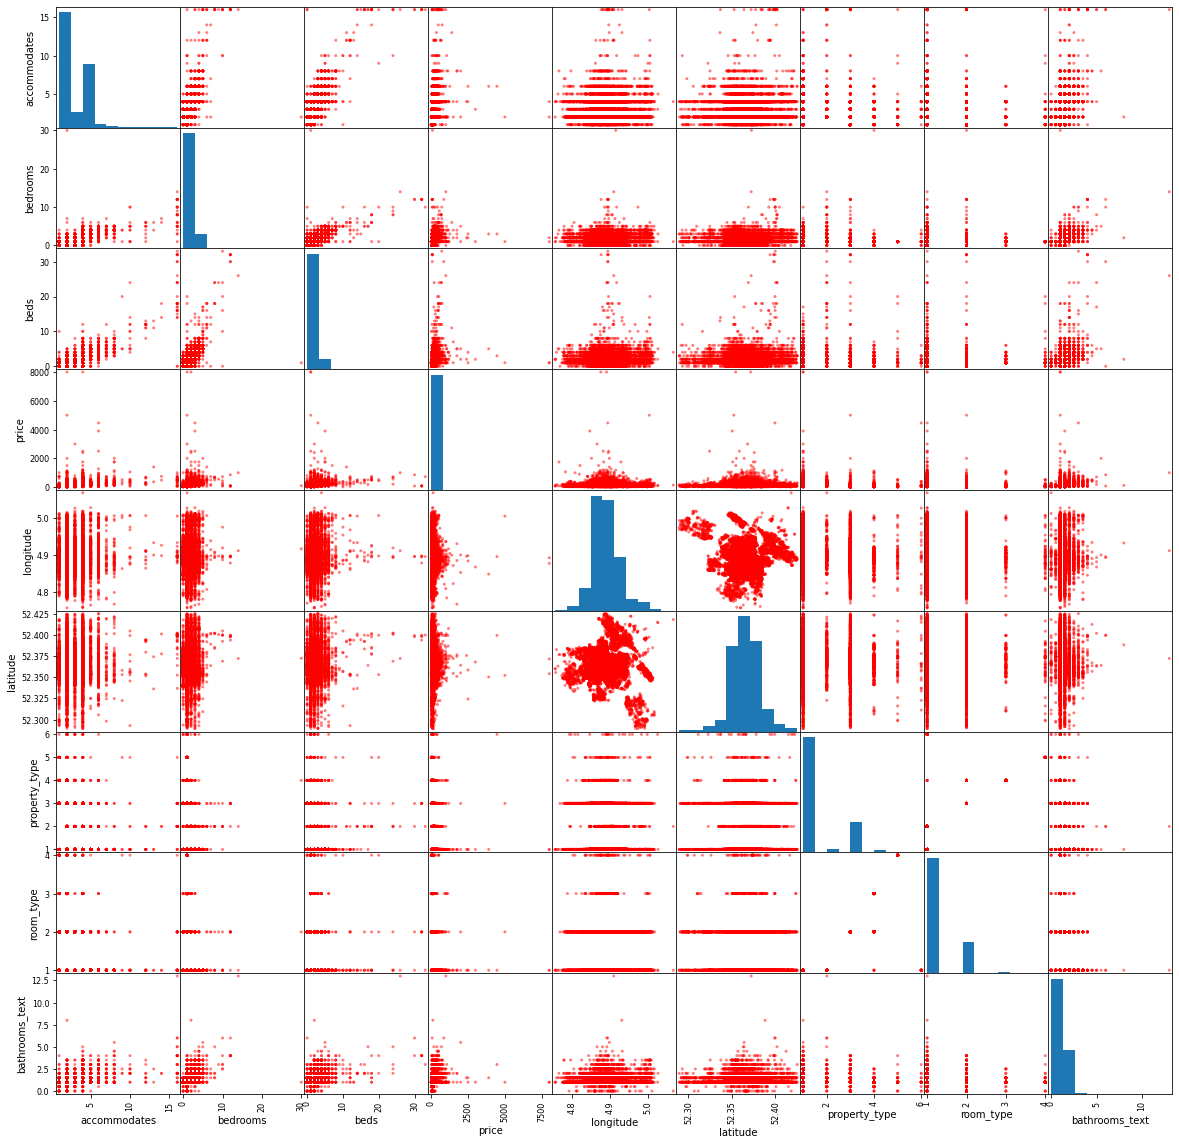

In [26]:
# check for collinearity and visualize relationship between each predictor and price

matrix_cols = ['accommodates', 'bedrooms', 'beds', 'price', 'longitude', 'latitude', 'property_type', 'room_type','bathrooms_text']
axis = pd.plotting.scatter_matrix(prop_df2[matrix_cols], figsize=(20, 20), c='red')

In [27]:
X = prop_df3.drop(['price', 'propertyId', 'host_id','neighbourhood','beds'], axis=1)
y = prop_df3['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13141, 17)
(5632, 17)
(13141,)
(5632,)


Method 1: Using RandomForestRegressor

In [28]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)
dtf = pd.DataFrame()
dtf['true'] = y_test
dtf['pred'] = model.predict(X_test)
dtf.head(15)

,true,pred
14398,133.57,143.2110
4189,35.00,44.2800
7377,125.00,140.3142
11841,200.00,162.1000
614,64.00,65.1500
16374,183.00,165.5868
17403,119.00,192.1000
15489,210.00,408.5300
7612,125.00,118.9000
3165,245.00,274.2128


In [29]:
importances = model.feature_importances_
column_names = X_train.columns
 
for imp, c in sorted(zip(importances,column_names), key=lambda pair: pair[0], reverse=True):
  print('{:20}:   {}'.format(c, imp))
  



longitude           :   0.38588360605400734
latitude            :   0.25558621061394937
accommodates        :   0.14698921188259784
bathrooms_text      :   0.06348063930954713
property_type_6     :   0.0418079672071833
bedrooms            :   0.04066207212407365
instant_bookable    :   0.021582722469732713
room_type_1         :   0.012142755481306212
host_is_superhost   :   0.0116451751619861
room_type_2         :   0.008108387446663612
property_type_3     :   0.004408944066162636
property_type_1     :   0.00290064231010691
property_type_2     :   0.0025994392409398196
property_type_4     :   0.0010853303797533726
room_type_3         :   0.0008929233133759146
property_type_5     :   0.00011411714871887615
room_type_4         :   0.00010985578989525802


In [30]:
print(mean_absolute_error(y_test, model.predict(X_test)))

54.88940578596371


Method 2: using LinearRegression

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
 
for c, num in zip(X.columns, lr.coef_):
  print('{:20}:   {}'.format(c, num))
 
dttf = pd.DataFrame()
 
dttf['true'] = y_train
dttf['pred'] = lr.predict(X_train)
 
dttf.tail()


0.15638930084031188
longitude           :   -76.40897000581114
latitude            :   -212.7066008486445
accommodates        :   25.119735805364023
bathrooms_text      :   36.04013662904878
bedrooms            :   10.908704134037636
instant_bookable    :   5.922827642248712
host_is_superhost   :   2.9906933190049303
room_type_1         :   80.12700461836644
room_type_2         :   -44.73536930396845
room_type_3         :   -10.315707738851934
room_type_4         :   -25.07592757554538
property_type_1     :   -78.96870561479884
property_type_2     :   -49.013145093889065
property_type_3     :   -4.533288613858901
property_type_4     :   11.112337705359064
property_type_5     :   -25.075927575545677
property_type_6     :   146.4787291927338


,true,pred
1867,280.0,239.494436
10705,176.0,180.327234
447,80.0,135.162950
6861,350.0,235.495800
13222,800.0,235.210400


In [32]:
print(mean_absolute_error(y_test, lr.predict(X_test)))

55.739160699554304


Method 3: using DecisionTreeRegression

In [33]:
dtr = DecisionTreeRegressor(random_state = 42)
dtr.fit(X_train, y_train)
print(mean_absolute_error(y_test, dtr.predict(X_test)))

70.17638565340908


The best result was produced by LinearRegression. However the mean absolute error was pretty high (~55). Linear Regression gets affected by outliers so we decided to remove the outliers. We chose to remove properties that had a price less than the 5% and more than the 95% of all the prices.

In [34]:
prop_df3['price'].quantile(q=0.95)

325.0

In [35]:
prop_df3['price'].quantile(q=0.05)

55.0

In [36]:
#prop_df4 is a dataframe that contains the 5%<prices<95%

prop_df4=prop_df3[prop_df3['price'] <= prop_df3['price'].quantile(q=0.95)]
prop_df4=prop_df4[prop_df4['price'] >= prop_df3['price'].quantile(q=0.05)]

In [37]:
#prop_df5 is a dataframe that contains prices<5% and prices>95% (in other words, the prices that we dropped before)

prop_df5=prop_df3[prop_df3['price'] > prop_df3['price'].quantile(q=0.95)]
prop_df5=prop_df3[prop_df3['price'] < prop_df3['price'].quantile(q=0.05)].append(prop_df5)

In [38]:
prop_df4.shape

(16914, 22)

In [39]:
#this is training the prop_df4 database

X2 = prop_df4.drop(['price', 'propertyId', 'host_id','neighbourhood','beds'], axis=1)
y2 = prop_df4['price']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.3)
print(X2_train.shape)
print(X2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(11839, 17)
(5075, 17)
(11839,)
(5075,)


In [40]:
dtr2 = DecisionTreeRegressor(random_state = 42)
dtr2.fit(X2_train, y2_train)
print(mean_absolute_error(y2_test, dtr2.predict(X2_test)))

48.32253513957307


In [41]:
model2 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model2.fit(X2_train, y2_train)
dtf2 = pd.DataFrame()
dtf2['true'] = y2_test
dtf2['pred'] = model2.predict(X2_test)
dtf2.head(15)

,true,pred
16015,269.0,190.070000
17974,80.0,69.420000
905,75.0,94.066667
10502,197.0,115.230000
7609,106.0,165.060000
13248,206.0,148.550000
5485,171.0,163.580000
11813,200.0,144.860000
12668,190.0,152.420000
12789,209.0,221.300000


In [42]:
importances = model2.feature_importances_
column_names = X2_train.columns
 
for imp, c in sorted(zip(importances,column_names), key=lambda pair: pair[0], reverse=True):
  print('{:20}:   {}'.format(c, imp))

longitude           :   0.2969979021067953
latitude            :   0.27554441636682947
accommodates        :   0.20838594874347488
bedrooms            :   0.06597285152827667
room_type_1         :   0.040614679692850736
bathrooms_text      :   0.035816939940127704
instant_bookable    :   0.024000790456743516
room_type_2         :   0.015968372381987162
host_is_superhost   :   0.015072170885886877
property_type_3     :   0.009547967661597597
property_type_2     :   0.005126878500173191
property_type_1     :   0.003951782282342592
property_type_4     :   0.0017021151835748538
room_type_3         :   0.0006967573009630301
room_type_4         :   0.00025207996741559126
property_type_5     :   0.0002318104678100785
property_type_6     :   0.00011653653315088578


In [43]:
print(mean_absolute_error(y2_test, model2.predict(X2_test)))

36.68095596314307


We will run the linear regression model again on our new dataframe: prop_df4

In [44]:
#this is training the prop_df5 database (the one with the outliers)

X3 = prop_df5.drop(['price', 'propertyId', 'host_id','neighbourhood','beds'], axis=1)
y3 = prop_df5['price']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3, test_size=0.3)
print(X3_train.shape)
print(X3_test.shape)
print(y3_train.shape)
print(y3_test.shape)

(1301, 17)
(558, 17)
(1301,)
(558,)


In [45]:
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
print(lr2.score(X2_train, y2_train))
 
print(mean_squared_error(y2_test, lr2.predict(X2_test)))
 
for c, num in zip(X2.columns, lr2.coef_):
  print('{:20}:   {}'.format(c, num))
 
dttf2 = pd.DataFrame()
 
dttf2['true'] = y2_train
dttf2['pred'] = lr2.predict(X2_train)
 
dttf2.tail()

0.2878892636856195
2440.916118536332
longitude           :   -37.00857609833674
latitude            :   -97.58648302809225
accommodates        :   12.60794945312771
bathrooms_text      :   13.897171643596977
bedrooms            :   10.326510774321147
instant_bookable    :   1.4357655101584337
host_is_superhost   :   4.536399218908393
room_type_1         :   129.98814887423657
room_type_2         :   -76.52261113520869
room_type_3         :   -69.12793834000213
room_type_4         :   15.662400600974346
property_type_1     :   -68.65791683750798
property_type_2     :   -41.86847839823144
property_type_3     :   96.69724122515788
property_type_4     :   110.26788299680433
property_type_5     :   15.662400600974328
property_type_6     :   -112.10112958719684


,true,pred
3324,150.0,171.884488
7134,115.0,154.106867
14062,114.0,129.733645
16005,128.0,120.495192
1215,60.0,119.639154


In [46]:
#we check our mean absolute error if we train and test on the prop_df4 database

print(mean_absolute_error(y2_test, lr2.predict(X2_test)))

38.02642781737626


In [47]:
#we check our mean absolute error if we train on the prop_df4 database and test on the original prop_df3 database

print(mean_absolute_error(y_test, lr2.predict(X_test)))

55.51985029293922


In [48]:
#we check our mean absolute error if we train on the prop_df4 database and test on the prop_df5 database (the one with the outliers)

print(mean_absolute_error(y3_test, lr2.predict(X3_test)))

192.01255958285833


We try to improve our model by using cross validation

In [49]:
param_grid = {}
grid = GridSearchCV(model2, param_grid, cv=6, scoring='neg_mean_absolute_error')
grid.fit(X2,y2)

GridSearchCV(cv=6, estimator=RandomForestRegressor(n_jobs=-1), param_grid={},
             scoring='neg_mean_absolute_error')

In [50]:
mean1=mean_absolute_error(y2_test, grid.predict(X2_test))
print(mean1)

13.577945936758042


## We will use the predictions to find the most underpriced and overpriced values

In [51]:
#adding the predictions to our dataframe prop_df4
prop_df8=pd.DataFrame()
prop_df8=prop_df8.append(prop_df4)
predictions=grid.predict(X2)
prop_df8['predictions']=predictions

1st method: To use the mean absolute error


Overpriced are the properties that cost more than the sum of the predicted price and the mean absolute error (~36€). 
E.g. If a property is predicted 100€ then the price of the property shouldn't be more than 136€.

Underpriced are the properties that cost less than the difference of the predicted price and the mean absolute error (~36€). 
E.g. If a property is predicted 100€ then the price of the property shouldn't be less than 64€.

In [52]:
prediction_df=prop_df8.drop(['room_type_1','room_type_2','room_type_3','room_type_4','property_type_1','property_type_2','property_type_3','property_type_4','property_type_5','property_type_6'],axis=1)
prediction_df.head()

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,neighbourhood,host_is_superhost,predictions
0,2818,4.94142,52.36575,2,1.5,1.0,2.0,59.0,1,3159,Oostelijk Havengebied - Indische Buurt,1.0,66.200000
1,20168,4.89396,52.36424,2,1.0,1.0,1.0,236.0,1,59484,Centrum-Oost,0.0,182.837967
2,25428,4.88339,52.37297,3,1.0,1.0,1.0,125.0,0,56142,Centrum-West,1.0,136.370000
3,27886,4.89188,52.38761,2,1.5,1.0,1.0,138.0,1,97647,Centrum-West,1.0,125.300000
4,28871,4.89092,52.36719,2,1.0,1.0,1.0,75.0,0,124245,Centrum-West,1.0,81.280000


In [53]:
#We will find the property id's of the properties that are either overpriced or underpriced.

overpriced=[]
underpriced=[]
for i in range(len(prediction_df)):
  if prediction_df.iloc[i,12]+mean1<prediction_df.iloc[i,7]:
    overpriced.append(prediction_df.iloc[i,0])
  elif prediction_df.iloc[i,12]-mean1>prediction_df.iloc[i,7]:
    underpriced.append(prediction_df.iloc[i,0])
print('The overpriced properties are: ',overpriced)
print('The underpriced properties are: ',underpriced)

The overpriced properties are:  [20168, 31080, 49790, 69042, 82748, 84057, 155548, 175989, 179528, 212050, 213721, 217692, 219276, 254104, 254800, 255809, 283621, 305809, 307497, 309436, 311124, 314673, 331946, 361342, 367107, 378523, 379885, 384909, 387644, 408794, 414917, 432233, 440992, 450767, 480245, 490374, 502869, 543932, 544506, 551606, 581342, 581869, 582030, 594474, 606871, 609250, 620056, 623652, 658049, 660856, 667305, 679838, 690757, 702894, 705423, 711952, 721897, 728144, 728145, 731834, 744659, 754020, 758600, 759299, 760599, 768274, 780674, 784277, 789743, 794322, 798941, 807269, 818079, 823448, 842774, 846458, 847730, 849993, 862411, 862446, 874057, 877702, 881558, 885008, 892937, 895684, 895792, 916850, 923247, 927119, 929281, 938669, 989222, 996112, 1005026, 1021278, 1036888, 1037485, 1041013, 1055570, 1055764, 1076673, 1081452, 1087866, 1105924, 1107057, 1109494, 1114384, 1129677, 1136289, 1156220, 1159204, 1159534, 1182550, 1187004, 1197874, 1213011, 1237950, 12462

In [54]:
len(overpriced)

3123

In [55]:
len(underpriced)

3331

2nd method: To find the differences between the predicted price and the original price

In [56]:
dif_pred=[]
for i in range(len(prediction_df)):
    pred=prediction_df.iloc[i,7]-prediction_df.iloc[i,12]
    dif_pred.append(pred)
prediction_df['dif_pred']=dif_pred

In [57]:
prediction_df.head()

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,neighbourhood,host_is_superhost,predictions,dif_pred
0,2818,4.94142,52.36575,2,1.5,1.0,2.0,59.0,1,3159,Oostelijk Havengebied - Indische Buurt,1.0,66.200000,-7.200000
1,20168,4.89396,52.36424,2,1.0,1.0,1.0,236.0,1,59484,Centrum-Oost,0.0,182.837967,53.162033
2,25428,4.88339,52.37297,3,1.0,1.0,1.0,125.0,0,56142,Centrum-West,1.0,136.370000,-11.370000
3,27886,4.89188,52.38761,2,1.5,1.0,1.0,138.0,1,97647,Centrum-West,1.0,125.300000,12.700000
4,28871,4.89092,52.36719,2,1.0,1.0,1.0,75.0,0,124245,Centrum-West,1.0,81.280000,-6.280000


In [58]:
sorted_pred_df=prediction_df.sort_values(by='dif_pred',ascending=False)

In [59]:
sorted_pred_df.shape

(16914, 14)

In [60]:
sorted_pred_df.head()

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,neighbourhood,host_is_superhost,predictions,dif_pred
6249,13381773,4.80801,52.38037,3,2.0,1.0,0.0,300.0,0,76064440,Geuzenveld - Slotermeer,0.0,211.28,88.72
12665,25676704,4.88737,52.35100,2,1.0,1.0,1.0,320.0,0,24440127,De Pijp - Rivierenbuurt,0.0,234.94,85.06
7672,15595655,4.85108,52.35643,2,1.0,1.0,2.0,300.0,0,16911797,Zuid,1.0,215.40,84.60
2801,6149173,4.94467,52.37678,2,1.0,1.0,1.0,300.0,0,31379572,Oostelijk Havengebied - Indische Buurt,0.0,216.24,83.76
16155,36970315,4.91687,52.38295,3,1.0,1.0,2.0,300.0,1,224920981,Oud-Noord,0.0,217.71,82.29


In [61]:
sorted_pred_df.tail()

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,neighbourhood,host_is_superhost,predictions,dif_pred
7431,15106989,4.90941,52.35733,4,2.0,4.0,6.0,90.0,0,4109856,Oud-Oost,0.0,150.07,-60.07
13946,29407363,4.93610,52.35549,5,3.0,3.0,4.0,120.0,0,12677835,Watergraafsmeer,0.0,184.19,-64.19
18509,44692108,4.90511,52.37576,2,1.0,2.0,3.0,79.0,0,352683767,Centrum-Oost,0.0,143.21,-64.21
5532,12130212,4.88201,52.37278,2,1.0,1.0,2.0,95.0,0,65095912,Centrum-West,0.0,162.02,-67.02
14825,32337426,4.89196,52.37665,4,1.5,2.0,1.0,75.0,0,242773168,Centrum-West,0.0,142.55,-67.55


In [62]:
print('The 20 most overpriced properties are:')
for i in range(0,20):
  print(sorted_pred_df.iloc[i,0])

The 20 most overpriced properties are:
13381773
25676704
15595655
6149173
36970315
45460221
28175216
16695338
15628462
2934713
41526891
1562942
22301898
28840083
18130060
15839201
15154695
44297962
35176645
21021923


In [63]:
sorted_pred_df.shape

(16914, 14)

In [64]:
print('The 20 most underpriced properties are:')
x=len(sorted_pred_df)
for i in range(x-1,x-21,-1):
  print(sorted_pred_df.iloc[i,0])

The 20 most underpriced properties are:
32337426
12130212
44692108
29407363
15106989
30930837
32109851
35570381
9323289
16988813
38121875
26649731
25735095
3929712
12482590
2464037
16390447
28270449
44090665
18371253


## We will see if the 20 underpriced properties should change their prices according to their reviews

In [65]:
revS_df.head()

,propertyId,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review_key,last_review_key,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,2818,278,6,0,20090330.0,20200214.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1.98
1,20168,340,48,0,20100302.0,20200409.0,89.0,10.0,10.0,10.0,10.0,10.0,9.0,2.63
2,25428,5,2,0,20180121.0,20200209.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.15
3,27886,219,16,0,20120109.0,20200725.0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,2.05
4,28871,336,32,2,20100822.0,20200920.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2.72


In [66]:
#We will use describe to see what is considered a good percentage for a review_scores_rating

revS_df['review_scores_rating'].describe()

count    16240.000000
mean        95.177094
std          6.841266
min         20.000000
25%         93.000000
50%         97.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

In [67]:
#We will create a datframe with the 20 most undervalued properties: most_underpriced

most_underpriced=sorted_pred_df.iloc[-20:]
most_underpriced.head(25)

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,neighbourhood,host_is_superhost,predictions,dif_pred
9048,18371253,4.93094,52.36920,4,1.0,3.0,4.0,79.0,0,104668830,Centrum-Oost,0.0,135.7300,-56.7300
18308,44090665,4.91084,52.36790,6,2.0,3.0,3.0,136.0,1,353874294,Centrum-Oost,0.0,192.8200,-56.8200
13607,28270449,4.89565,52.35464,4,1.0,2.0,2.0,89.0,1,26843240,De Pijp - Rivierenbuurt,0.0,146.0300,-57.0300
8097,16390447,4.88457,52.37654,2,1.5,1.0,1.0,69.0,1,107367516,Centrum-West,0.0,126.0914,-57.0914
1207,2464037,4.93039,52.36069,5,1.5,3.0,3.0,90.0,0,3653201,Oud-Oost,0.0,147.1900,-57.1900
5688,12482590,4.87569,52.36537,4,1.0,3.0,3.0,110.0,0,5721466,De Baarsjes - Oud-West,0.0,167.3200,-57.3200
1896,3929712,4.89600,52.37598,4,2.0,1.0,1.0,57.0,0,20358179,Centrum-West,1.0,114.4800,-57.4800
12682,25735095,4.92546,52.39417,4,1.5,2.0,2.0,57.0,0,4668971,Oud-Noord,1.0,114.5000,-57.5000
12994,26649731,4.89520,52.37797,1,1.5,1.0,1.0,74.0,0,146766943,Centrum-West,0.0,131.9300,-57.9300
16457,38121875,4.89604,52.35757,2,1.0,1.0,1.0,80.0,0,126873612,De Pijp - Rivierenbuurt,1.0,138.4900,-58.4900


In [68]:
#We will merge the most_underpriced dataframe with the reviewsSummary(revS_df) dataframe

most_underpriced=pd.merge(most_underpriced,revS_df, how='left', on='propertyId')
most_underpriced.head(20)

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,...,first_review_key,last_review_key,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,18371253,4.93094,52.36920,4,1.0,3.0,4.0,79.0,0,104668830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44090665,4.91084,52.36790,6,2.0,3.0,3.0,136.0,1,353874294,...,20200711.0,20200711.0,20.0,2.0,2.0,2.0,2.0,2.0,2.0,0.33
2,28270449,4.89565,52.35464,4,1.0,2.0,2.0,89.0,1,26843240,...,20181001.0,20200906.0,95.0,10.0,9.0,10.0,10.0,10.0,10.0,0.48
3,16390447,4.88457,52.37654,2,1.5,1.0,1.0,69.0,1,107367516,...,20170102.0,20200901.0,93.0,9.0,8.0,10.0,10.0,10.0,9.0,0.98
4,2464037,4.93039,52.36069,5,1.5,3.0,3.0,90.0,0,3653201,...,20140629.0,20191229.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0.05
5,12482590,4.87569,52.36537,4,1.0,3.0,3.0,110.0,0,5721466,...,20160430.0,20200802.0,99.0,10.0,10.0,10.0,10.0,10.0,9.0,0.44
6,3929712,4.89600,52.37598,4,2.0,1.0,1.0,57.0,0,20358179,...,20140825.0,20200922.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,6.27
7,25735095,4.92546,52.39417,4,1.5,2.0,2.0,57.0,0,4668971,...,20180820.0,20180828.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.08
8,26649731,4.89520,52.37797,1,1.5,1.0,1.0,74.0,0,146766943,...,20180812.0,20200720.0,100.0,10.0,10.0,10.0,10.0,10.0,9.0,0.30
9,38121875,4.89604,52.35757,2,1.0,1.0,1.0,80.0,0,126873612,...,20190911.0,20191202.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.68


In [69]:
#We will drop the column which are not needed. We will only work with the review_scores_rating

most_underpriced=most_underpriced.drop(['number_of_reviews', 'number_of_reviews_ltm', 'first_review_key',
                                        'last_review_key','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                                        'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month','number_of_reviews_l30d'], axis=1)
most_underpriced.head(20)

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,neighbourhood,host_is_superhost,predictions,dif_pred,review_scores_rating
0,18371253,4.93094,52.36920,4,1.0,3.0,4.0,79.0,0,104668830,Centrum-Oost,0.0,135.7300,-56.7300,NaN
1,44090665,4.91084,52.36790,6,2.0,3.0,3.0,136.0,1,353874294,Centrum-Oost,0.0,192.8200,-56.8200,20.0
2,28270449,4.89565,52.35464,4,1.0,2.0,2.0,89.0,1,26843240,De Pijp - Rivierenbuurt,0.0,146.0300,-57.0300,95.0
3,16390447,4.88457,52.37654,2,1.5,1.0,1.0,69.0,1,107367516,Centrum-West,0.0,126.0914,-57.0914,93.0
4,2464037,4.93039,52.36069,5,1.5,3.0,3.0,90.0,0,3653201,Oud-Oost,0.0,147.1900,-57.1900,95.0
5,12482590,4.87569,52.36537,4,1.0,3.0,3.0,110.0,0,5721466,De Baarsjes - Oud-West,0.0,167.3200,-57.3200,99.0
6,3929712,4.89600,52.37598,4,2.0,1.0,1.0,57.0,0,20358179,Centrum-West,1.0,114.4800,-57.4800,98.0
7,25735095,4.92546,52.39417,4,1.5,2.0,2.0,57.0,0,4668971,Oud-Noord,1.0,114.5000,-57.5000,100.0
8,26649731,4.89520,52.37797,1,1.5,1.0,1.0,74.0,0,146766943,Centrum-West,0.0,131.9300,-57.9300,100.0
9,38121875,4.89604,52.35757,2,1.0,1.0,1.0,80.0,0,126873612,De Pijp - Rivierenbuurt,1.0,138.4900,-58.4900,98.0


In [70]:
#If a property has better review score than the 50% of the properties 
#then we consider that the property needs to increase the price.

for i in range(len(most_underpriced)):
  if most_underpriced.iloc[i,14]>=revS_df['review_scores_rating'].quantile(q=0.5):
    print('Property ',most_underpriced.iloc[i,0],'should increase the price')

Property  12482590 should increase the price
Property  3929712 should increase the price
Property  25735095 should increase the price
Property  26649731 should increase the price
Property  38121875 should increase the price
Property  35570381 should increase the price
Property  30930837 should increase the price
Property  15106989 should increase the price
Property  44692108 should increase the price


## Function to calculated the price of a new listing

In [71]:
def tell_me_price():
  lon=input('Enter the longitude: ')
  lat=input('Enter the latitude: ')
  acc=input('Enter the number of people that the property can accommodate: ')
  bath=input('Enter the number of bathrooms: ')
  bed=input('Enter the number of bedrooms: ')
  room=input('Enter the room type: ')
  insta=input('Is the property instable bookable? ')
  super=input('Are you a superhost? ')
  property=input('Enter the property type: ')

  predict_df=pd.DataFrame()
  predict_df['longitude']=[float(lon)]
  predict_df['latitude']=[float(lat)]
  predict_df['accommodates']=[int(acc)]
  predict_df['bathrooms_text']=[float(bath)]
  predict_df['bedrooms']=[int(bed)]
  predict_df['instant_bookable']=[int(insta)]
  predict_df['host_is_superhost']=[int(super)]

  for i in range(4):
    if (str(room) in ("room_type_" + str(i+1))):
      predict_df["room_type_" + str(i+1)]=[1]
    else:
      predict_df["room_type_" + str(i+1)]=[0]

  for i in range(6):
    if (str(property) in ("property_type_" + str(i+1))):
      predict_df["property_type_" + str(i+1)]=[1]
    else:
      predict_df["property_type_" + str(i+1)]=[0]
  
  return(predict_df)

In [81]:
price=grid.predict(tell_me_price())
print('The recommended price you should charge is:',round(price[0],2),'€')

Enter the longitude: 4.93094
Enter the latitude: 52.36920	
Enter the number of people that the property can accommodate: 4
Enter the number of bathrooms: 2
Enter the number of bedrooms: 2
Enter the room type: Double
Is the property instable bookable? 1
Are you a superhost? 1
Enter the property type: Entire home
The recommended price you should charge is: 184.4 €


Check if there is a correlation between price and reviews


In [75]:
rev_prop=pd.merge(prop_df8,revS_df, how='left', on='propertyId')
rev_prop.head()
null_df=rev_prop[rev_prop['review_scores_rating'].isnull()]
null_df.head()

,propertyId,longitude,latitude,accommodates,bathrooms_text,bedrooms,beds,price,instant_bookable,host_id,...,first_review_key,last_review_key,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
178,517092,4.85545,52.36138,5,1.0,4.0,3.0,120.0,0,2041793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,626872,4.87519,52.37625,2,1.0,1.0,1.0,150.0,0,3111814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,665250,4.89882,52.35108,4,1.0,2.0,2.0,139.0,0,3361425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,680137,4.90142,52.37201,2,1.0,1.0,2.0,200.0,1,3440799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,721897,4.86993,52.38435,2,1.0,1.0,1.0,149.0,0,3727363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
rev_prop=rev_prop[['propertyId','price','review_scores_rating']]
rev_prop=rev_prop.dropna()
rev_prop.head()

,propertyId,price,review_scores_rating
0,2818,59.0,98.0
1,20168,236.0,89.0
2,25428,125.0,100.0
3,27886,138.0,99.0
4,28871,75.0,97.0


In [77]:
rev_prop.shape

(14734, 3)

In [78]:
from sklearn.cluster import KMeans
import seaborn as sns

In [79]:
array_1 = rev_prop["price"].to_list()
array_2 =  rev_prop["review_scores_rating"].to_list()
my_ar = np.array([array_1, array_2])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'correlation between price and reviews')

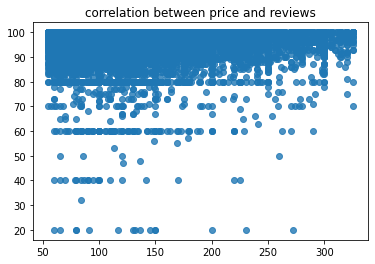

In [80]:
sns.regplot(array_1, array_2).set_title('correlation between price and reviews')